# Practical Exercise 2 (_Práctica 2_)


## Objectives

- Preprocessing a downloaded dataset
- Reshaping a dataset
- Merging multiple DataFrames
- Resampling and grouping
- Creating visualizations using pandas, matplotlib and seaborn

## Instructions

This exercise is purely practical.
Please take into account the following indications:

There are some code cells that you have to fill, following the instructions.
You are requested to change the following code piece with your solutions.

---
```python
# YOUR CODE HERE
raise NotImplementedError()
```
---

Similarly, there are some questions that you must answer.
You should answer in the cells that are marked with the following sentence:

---

# YOUR ANSWER HERE
---

There are some code cells that can not be modified (they have a yellow background color).
These cells contain small tests, aimed to help you.
You can use these cells to check that your code is, at least, partially correct.
Please take into account that even if these cells do not raise any errors, **it does not mean** that the code is correct.

## Loading datasets (15/100)

### Census (population) 

The first dataset we will use contains census data for Spain in multiple years.
The data is provided as an HTML page that contains a single table.

Read the table into a DataFrame named `censo`. The index of `censo` should contain the dates of each data value as a string.
The columns should be a MultiIndex, whose first level will be region (`Andalucía`, `Aragón`, ...), the second level will be age (`Total`, `0 años`, `1 año`...) and the third level has values `Hombres` and `Mujeres`.

All the numbers **should be integers** (round down as needed). If there are any invalid values, they should be considered as 0.

## Importante

Para realizar la práctica se necesitan los archivos del INE
Puede encontrarlos en el siguiente enlace: https://drive.google.com/file/d/1q-7Hp_Ger_SrYMJ7WdtB7a2quOx9qgLc/view?usp=sharing

Una vez descargados, descomprima la carpeta y pégela dentro de Práctica 2 PBDA

In [1]:
### BEGIN SOLUTION
import pandas as pd

censo = pd.read_html('ResultadosINE2024.html', encoding='UTF-8')[0]
censo = censo.rename(columns={'Unnamed: 1': 'values','Unnamed: 0':'region','Unnamed: 2':'age'})
censo = censo.T   # Así hay índices lógicos
regions = censo.loc['region'] # Arrays para MuliIndex
values = censo.loc['values']
ages = censo.loc['age']
multi_index_columns = pd.MultiIndex.from_arrays(
    [regions, ages, values],
    names=['region', 'age', 'values'] # Crea un MultiIndex con las tres dimensiones: 
                                      # 'region', 'age' y 'values', y las asigna como niveles de columnas.
)
censo.columns = multi_index_columns
censo = censo.drop(['region', 'values', 'age'], axis=0) # Elimina las filas de encabezados 
                                                        # ('region', 'values', 'age') que ya no son necesarias.
new_region_levels = [
    value.split(' ', 1)[1] if isinstance(value, str) and ' ' in value else value
    for value in censo.columns.levels[0]
]
censo.columns = censo.columns.set_levels(new_region_levels, level=0)  # Ajusta el nivel de 'region' para eliminar códigos numéricos al principio 
                                                                      # (por ejemplo, convierte '01 Andalucía' en 'Andalucía').

censo = censo.replace({r'\.': '', r',': '.'}, regex=True) # Eliminar puntos de miles y cambia las comas por puntos decimales
censo = censo.apply(pd.to_numeric, errors='coerce') # Convierte todos los valores del DataFrame a tipo numérico. 
                                                    # Los valores no válidos se convierten en NaN.
censo = censo.fillna(0).astype(int)
# Rellena los valores NaN con 0 y convierte todo el DataFrame a enteros truncando los decimales.


### END SOLUTION

In [16]:
assert pd.api.types.is_object_dtype(censo.index)
assert "1 de julio de 2022" in censo.index
assert 'Aragón' in censo.columns.levels[0]
assert '100 y más años' in censo.columns.levels[1]
assert set(censo.columns.levels[2]) == {"Hombres", "Mujeres"}
assert 45643 in censo.values
assert all(dt == 'int' for dt in censo.dtypes)
censo_orig = censo.copy()

### Surveys

In addition to the population dataset, we will also make use of a dataset of surveys on salaries in Spain.
The surveys are conducted in regular intervals, and the results for each year are provided individually.

You may find the raw anonymized [data for 1995, 2002, 2006, 2010, 2014, 2018 and 2022 on INE's website](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177025&menu=resultados&idp=1254735976596#!tabs-1254736195110).

Your first task is to load the data for every year and merge all the information into a single DataFrame called `encuestas` that contains all survey results.

There are some changes in the way data are represented throughout the years, so we will follow some basic conventions:

- There will be a column `SALARIO` with yearly gross income in **euros**. In some of these datasets this information may be provided as subdivisions for specific sources (e.g., temporary incapacity). In those cases, **sum** all these subcategories.
- All the column names will be uppercase, and they will be preserved for future use.
- All `NaN` values will be preserved.

In [17]:
### BEGIN SOLUTION
df_Datos_INE_1995 = pd.read_csv('MicroDatos_INE/EES_cuatrienal_1995.csv', delimiter='\t') # Tiene columna salario bruto
df_Datos_INE_2002 = pd.read_csv('MicroDatos_INE/EES_cuatrienal_2002.csv', delimiter='\t') # Tiene columna salario bruto
df_Datos_INE_2006 = pd.read_csv('MicroDatos_INE/EES_cuatrienal_2006.csv', delimiter='\t') # Tiene columna salario bruto
df_Datos_INE_2010 = pd.read_csv('MicroDatos_INE/EES_2010.csv', delimiter='\t')            # Tiene columna salario bruto
df_Datos_INE_2014 = pd.read_csv('MicroDatos_INE/EES_2014.csv', delimiter='\t')            # Tiene columna salario bruto
df_Datos_INE_2018 = pd.read_csv('MicroDatos_INE/EES_2018.csv', delimiter='\t')
df_Datos_INE_2022 = pd.read_csv('MicroDatos_INE/EES_2022.tab', delimiter='\t')

df_Datos_INE_1995['ANO'] = 1995
df_Datos_INE_2002['ANO'] = 2002
df_Datos_INE_2006['ANO'] = 2006
df_Datos_INE_2010['ANO'] = 2010
df_Datos_INE_2014['ANO'] = 2014
df_Datos_INE_2018['ANO'] = 2018
df_Datos_INE_2022['ANO'] = 2022

df_Datos_INE_2018['SALBRUTO'] = df_Datos_INE_2018['RETRINOIN'] + df_Datos_INE_2018['RETRIIN'] + df_Datos_INE_2018['GEXTRA']     # Creamos la columna de salario bruto
df_Datos_INE_2022['SALBRUTO'] = df_Datos_INE_2022['RETRINOIN'] + df_Datos_INE_2022['RETRIIN'] + df_Datos_INE_2022['GEXTRA']

encuestas = pd.concat([df_Datos_INE_1995, df_Datos_INE_2002, df_Datos_INE_2006, df_Datos_INE_2010, df_Datos_INE_2014, df_Datos_INE_2018, df_Datos_INE_2022], ignore_index=True)     # Concatenamos los DataFrames
### END SOLUTION

In [18]:
assert len(encuestas) == 1510334
encuestas_orig = encuestas.copy()

## Pre-processing (15/100)

### Population 

In order to use our population DataFrame (`censo`), we will need to perform two main changes:

- Convert the index to a proper date.
- Store the yearly `Total` (for both males and females) in a variable called `censo_total`
- Store the yearly `Total` (for each region, including sum of males and females) in a variable called `censo_regiones`
- With **every other column but the Total and Region**, flatten the structure so that the columns reflect gender and age, and the index is the date. The `Edad` column should be computed from the appropriate column in the original censo dataset. For instance, `0 años` should map to `0`, `1 año` to `1` and so on. If an age group is labelled as `X y más años`, it should be mapped to `X` (e.g., `100 y más años` should become `100`). Store the result in `censo_edades`.

The end result for `censo_total` should look similar to this:

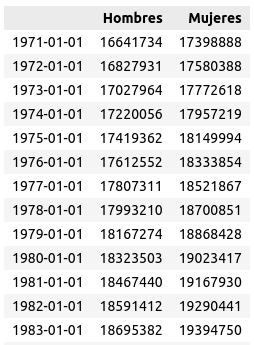

The end result for `censo_edades` should look similar to this:

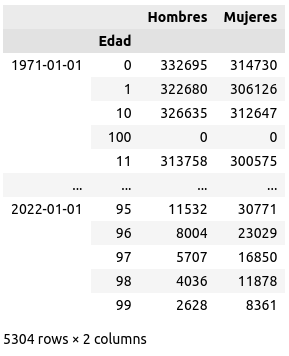

The end result for `censo_regiones` should look similar to this:

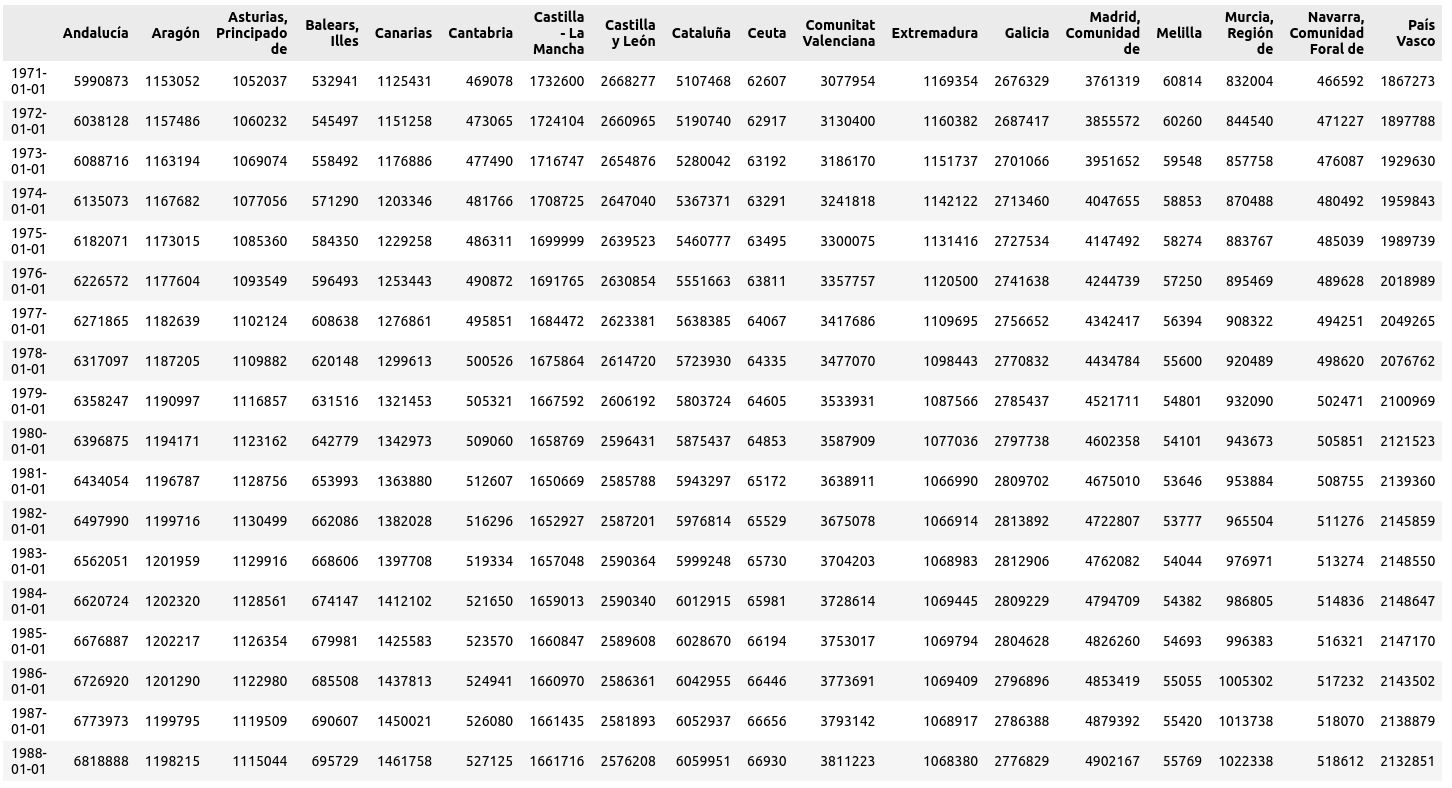


**Note**: use the same considerations for precision you did in the previous section.

**Note**: there may be more than one reading per year. In those cases, grab the earliest (i.e., January's data).

In [19]:
### BEGIN SOLUTION
idx = pd.IndexSlice
from locale import setlocale, LC_TIME
setlocale(LC_TIME, 'es_ES.UTF-8')     # Para que pandas reconozca los meses en español

censo.index = pd.to_datetime(censo.index, format='%d de %B de %Y')  # Convertir las fechas al formato deseado

df_personas = censo.xs(key='Total', level=1, axis=1)        # Vamos filtrando en el MultiIndex
df_hombres = df_personas.xs(key='Hombres', level=1, axis=1)
df_mujeres = df_personas.xs(key='Mujeres', level=1, axis=1)
df_hombres_sum = df_hombres.sum(axis=1)
df_mujeres_sum = df_mujeres.sum(axis=1)
censo_total = pd.DataFrame({                                # Construimos el DataFrame censo_total
    'Hombres': df_hombres_sum,
    'Mujeres': df_mujeres_sum
})

censo_regiones = pd.DataFrame()                             # Creamos el DataFrame censo_regiones vacío
for region in df_personas.columns.levels[0]:
    censo_regiones[f'{region}'] = df_personas[region]['Hombres'] + df_personas[region]['Mujeres']  # Ahora, creamos la columnas sumando el número total de hombres y de mujeres

### END SOLUTION

In [20]:
assert '1986' in censo_total.index
assert 'Hombres' in censo_total.columns
assert censo_total.index[0].tz_localize('Europe/Madrid') # If it is a date, it should be "localizable"
censo_timed = censo_total.copy()

In [9]:
assert 100 in censo_edades.index.levels[1]
assert 10 in censo_edades.index.levels[1]

NameError: name 'censo_edades' is not defined

In [21]:
assert 'Galicia' in censo_regiones.columns
assert 'Asturias, Principado de' in censo_regiones.columns
assert '2010-01-01' in censo_regiones.index

### Surveys 

The `SEXO` column in our `encuestas` dataset has a column `SEXO` with a numeric value.
Find out what sex corresponds to each number, and transform this column so that it contains a value of `hombre` for male participants, and `mujer` for females.

Find out the column in the survey data that indicates whether the person is working part time or full time (media jornada o jornada completa). In this column, assign the values `completa` to full time and `parcial` to part-time.

One column in the `encuestas` DataFrame represents the date for the row.
Identify that column, transform it to a datetime object, and set it as the index of the dataframe.

**Note**: we only need precision down to the year. You may disregard other parts of the date.

**For extra points**: Given that these are annual results, try to make the date should reflect the **end of the year**.

In [22]:
### BEGIN SOLUTION
sexo_map = {1: 'hombre', 6: 'mujer'}                                # Crear mapa
encuestas['SEXO'] = encuestas['SEXO'].map(sexo_map)                 # Mapear DataFrame
jornada_map = {1:'completa', 2:'parcial', 6:'otros' }
encuestas['TIPOJOR'] = encuestas['TIPOJOR'].map(jornada_map)
encuestas['ANO'] = pd.to_datetime(encuestas['ANO'], format='%Y')    # Transformar a objeto datetime
encuestas.set_index(encuestas['ANO'], inplace=True)                 # Poner año como índice

### END SOLUTION

In [23]:
assert {'hombre', 'mujer'} == set(encuestas.SEXO.unique())
assert '1995' in encuestas.index
assert '1994' not in encuestas.index
assert encuestas.index[0].tz_localize('Europe/Madrid') # If it is a date, it should be "localizable"
assert encuestas.iloc[:10].apply(lambda x: 'completa' in x.values or 'parcial' or 'otros' in x.values, axis=1).all() # Make sure all rows have a value of "completa" or "parcial"
encuestas_timed = encuestas.copy()

## Analysis  (15/100)

### Comparison of male and female respondents

- Which year saw the lowest difference in number of male and female respondents? Save the **year** in `year_of_minimum_difference` and the absolute value of the difference in `minimum_difference`
- Which year saw the lowest drop in male to female ratio relative to the previous survey? Save the **year** in `year_of_minimum_ratio_drop` and the ratio difference in `minimum_ratio_drop` (**note**: the difference may be negative)

In [24]:
### BEGIN SOLUTION
respondents_by_year = encuestas.groupby(encuestas.index.year)['SEXO'].value_counts().unstack()                  # Filtrar los encuestados por género en cada año
respondents_by_year.columns = ['hombre', 'mujer']                                                               # Renombrar las columnas para facilitar su uso
respondents_by_year['abs_difference'] = abs(respondents_by_year['hombre'] - respondents_by_year['mujer'])       # Calcular la diferencia absoluta entre hombres y mujeres

year_of_minimum_difference = respondents_by_year['abs_difference'].idxmin()                                     # Año con la menor diferencia absoluta
minimum_difference = respondents_by_year['abs_difference'].min()

respondents_by_year['male_to_female_ratio'] = respondents_by_year['hombre'] / respondents_by_year['mujer']      # Calcular el ratio hombre/mujer para cada año

respondents_by_year['ratio_difference'] = respondents_by_year['male_to_female_ratio'].diff()                    # Calcular la diferencia del ratio entre años consecutivos

year_of_minimum_ratio_drop = respondents_by_year['ratio_difference'].idxmin()                                   # Año con la menor caída del ratio
minimum_ratio_drop = respondents_by_year['ratio_difference'].min()

print(f"mínima diferencia absoluta: {year_of_minimum_difference}, diferencia: {minimum_difference}")
print(f"año de menor caída en ratio: {year_of_minimum_ratio_drop}, cambio en ratio: {minimum_ratio_drop}")

### END SOLUTION

mínima diferencia absoluta: 2022, diferencia: 24844
año de menor caída en ratio: 2002, cambio en ratio: -1.4617824273367945


In [25]:
assert year_of_minimum_difference > 2012
assert minimum_difference > 20000
assert minimum_difference < 30000
assert year_of_minimum_ratio_drop < 2012
assert abs(minimum_ratio_drop) < 2
assert abs(minimum_ratio_drop) > 1

### Percentage of part-time jobs

Calculate the annual percentage of part-time jobs from the surveys.
Save the value as a series named `porcentaje_parcial`.

In [26]:
### BEGIN SOLUTION
trabajos_parcial = encuestas[encuestas['TIPOJOR'] == 'parcial']                             # Filtrar los trabajos a tiempo parcial

total_trabajos_anuales = encuestas.groupby(encuestas.index.year).size()                     # Calcular el total de trabajos por año

total_parcial_anuales = trabajos_parcial.groupby(trabajos_parcial.index.year).size()        # Calcular el total de trabajos parciales por año

porcentaje_parcial = (total_parcial_anuales / total_trabajos_anuales) * 100                 # Calcular el porcentaje de trabajos parciales

porcentaje_parcial = porcentaje_parcial.sort_index()                                        # Asegurarse de que sea una serie con índices de años

porcentaje_parcial = porcentaje_parcial.fillna(0)                                           # Rellenamos los valores NaN con 0 

print(porcentaje_parcial)
### END SOLUTION

ANO
1995     0.000000
2002     0.000000
2006     0.000000
2010    16.676278
2014    17.627819
2018    17.972924
2022    17.840659
dtype: float64


In [27]:
assert porcentaje_parcial.max() > 15
assert porcentaje_parcial.min() < 5

### Population change

Identify the regions with the highest positive population increase and decrease over the last 10 years using the given census data. Store the values at variables named `highest_increase_region` and `highest_decrease_region`.

In [28]:
### BEGIN SOLUTION
censo_cambio_poblacion = censo_regiones.loc["2022-07-01"] - censo_regiones.loc["2012-07-01"]  # Usamos censo_regiones para calcular la diferencia

highest_increase_region = censo_cambio_poblacion.idxmax()                                     # Asignamos valores
highest_decrease_region = censo_cambio_poblacion.idxmin()

### END SOLUTION


In [29]:
assert highest_increase_region.__contains__('Madrid')
assert highest_decrease_region.__contains__('Castilla y León')

## Visualization (15/100)



Visualize the percentage change in population for each region over the last 10 years and classify them into three categories: 

- "High Growth" (>5%) 
- "Moderate Growth" (0-5%) 
- "Decline" (<5%)

Expected result:

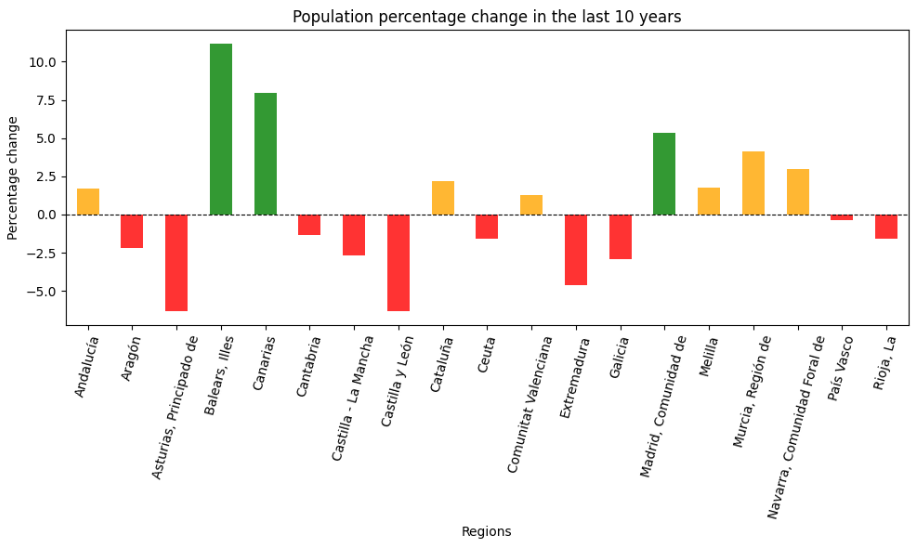

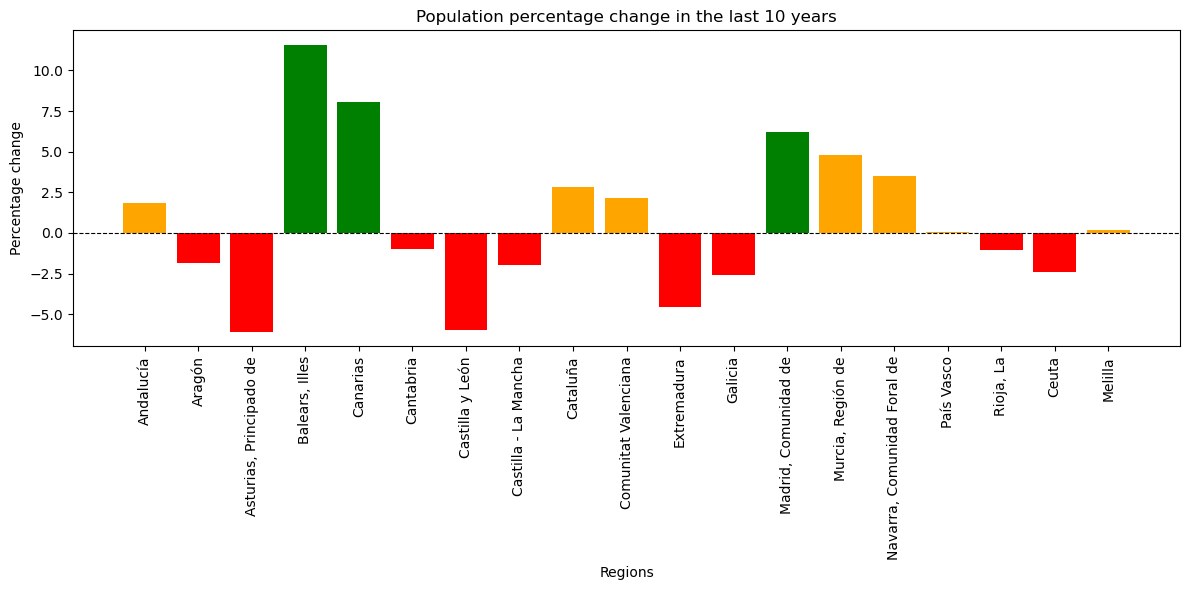

In [30]:
### BEGIN SOLUTION

import matplotlib.pyplot as plt
import numpy as np

censo_percentage_change = ((censo_regiones.loc["2022-07-01"] - censo_regiones.loc["2012-07-01"]) / censo_regiones.loc["2012-07-01"]) * 100  # Calculamos porcentajes

categories = pd.cut(
    censo_percentage_change,                                    # Creamos las categorías
    bins=[-np.inf, 0, 5, np.inf],
    labels=["Decline", "Moderate Growth", "High Growth"]
)

colors = categories.map({"Decline": "red", "Moderate Growth": "orange", "High Growth": "green"})              # Asignamos colores para cada categoría

plt.figure(figsize=(12, 6))                                                                                   # Pintar Gráfico
plt.bar(censo_percentage_change.index, censo_percentage_change, color=colors)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.xticks(rotation=90)
plt.title("Population percentage change in the last 10 years")
plt.xlabel("Regions")
plt.ylabel("Percentage change")
plt.tight_layout()
plt.show()

### END SOLUTION

Now visualize the same results but sorting the regions from highest population decrease to highest population increase

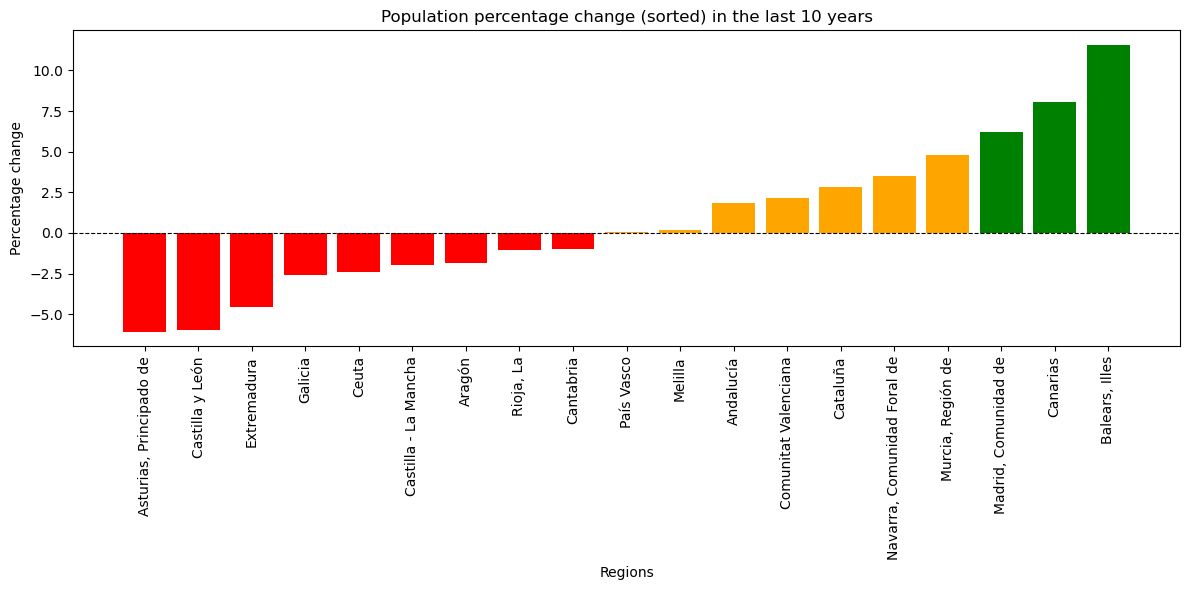

In [31]:
### BEGIN SOLUTION

sorted_censo_percentage_change = censo_percentage_change.sort_values()                   # Ordenamos dataset

sorted_categories = pd.cut(                                                              # Ordenamos categorías
    sorted_censo_percentage_change,     
    bins=[-np.inf, 0, 5, np.inf],
    labels=["Decline", "Moderate Growth", "High Growth"]
)

sorted_colors = sorted_categories.map({"Decline": "red", "Moderate Growth": "orange", "High Growth": "green"})  # Asignamos  colores a las categorías

plt.figure(figsize=(12, 6))
plt.bar(sorted_censo_percentage_change.index, sorted_censo_percentage_change, color=sorted_colors)   # Pintamos
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  
plt.xticks(rotation=90)
plt.title("Population percentage change (sorted) in the last 10 years")
plt.xlabel("Regions")
plt.ylabel("Percentage change")
plt.tight_layout()
plt.show()



### END SOLUTION

### Evolution of census and survey subjects

Visualize yearly trends in population and distribution of sex in the survey **over the last three decades**. Your graph should show, for every year:

- The total number of males
- The total number of females
- Number of female respondents in the survey
- Number of male respondents in the survey

Use appropriate legends, titles and any other elements that aid in interpretting your results. Feel free to use any type of smoothing.

C:\Users\AFLONSO\AppData\Local\Temp\ipykernel_18388\3859003431.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  census_males_smooth = census_males.resample('Y').sum().rolling(window=3, center=True).mean()                        # Combinamos las series para asegurarnos de que cubren todos los años
C:\Users\AFLONSO\AppData\Local\Temp\ipykernel_18388\3859003431.py:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  census_females_smooth = census_females.resample('Y').sum().rolling(window=3, center=True).mean()


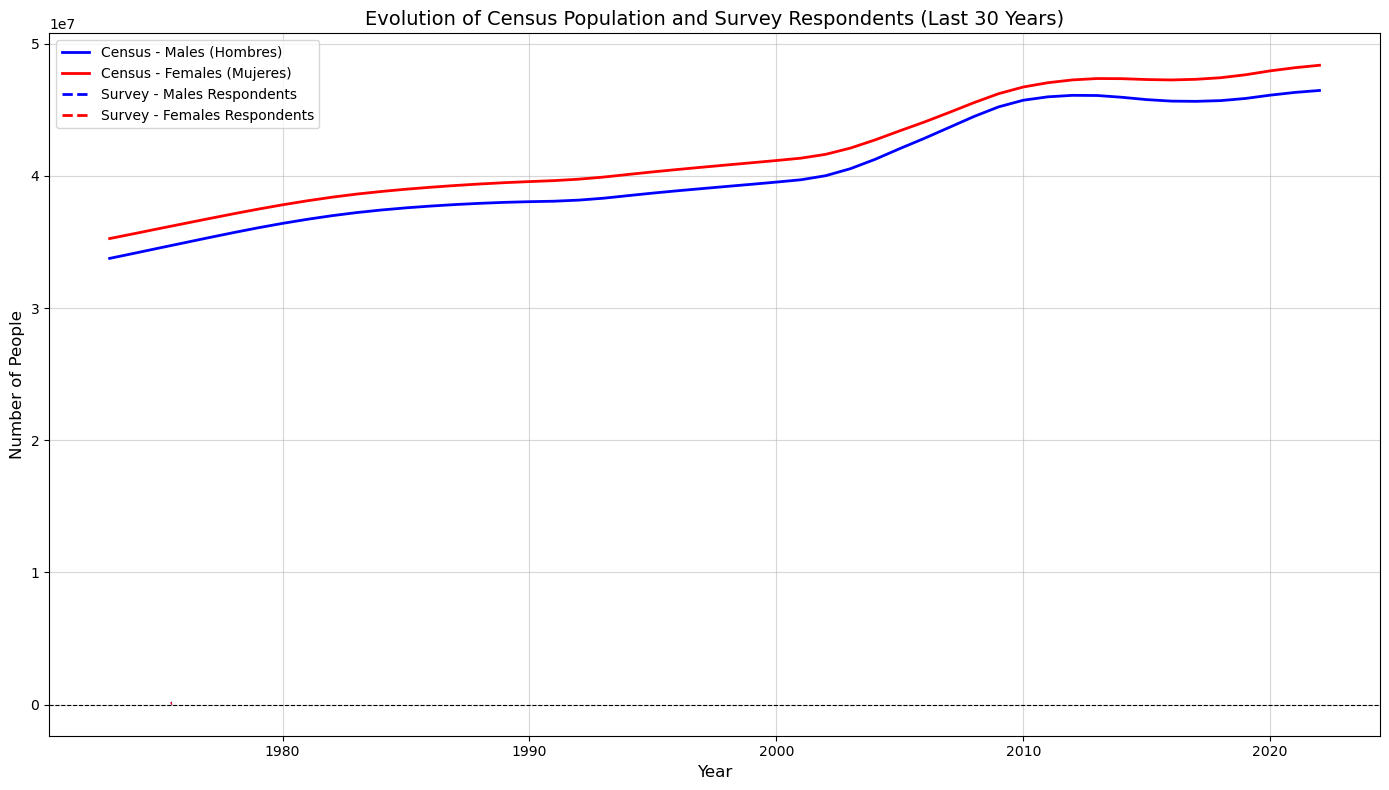

In [32]:
### BEGIN SOLUTION

start_year = censo_total.index.min().year  # Año inicial                                                            # Definir el rango de años
end_year = censo_total.index.max().year    # Año final

census_males = censo_total['Hombres']                                                                               # Extraer los datos censales
census_females = censo_total['Mujeres']

survey_males = encuestas_timed[encuestas_timed['SEXO'] == 'hombre']                                                 # Agrupar por años los datos de las encuestas (mujeres y hombres)
survey_males_grouped = survey_males.groupby(survey_males.index.year).size()

survey_females = encuestas_timed[encuestas_timed['SEXO'] == 'mujer']
survey_females_grouped = survey_females.groupby(survey_females.index.year).size()

census_males_smooth = census_males.resample('Y').sum().rolling(window=3, center=True).mean()                        # Combinamos las series para asegurarnos de que cubren todos los años
census_females_smooth = census_females.resample('Y').sum().rolling(window=3, center=True).mean()
survey_males_smooth = survey_males_grouped.rolling(window=3, center=True).mean()
survey_females_smooth = survey_females_grouped.rolling(window=3, center=True).mean()

plt.figure(figsize=(14, 8))                                                                                         # Ploteamos las líneas para la evolución de los censos y las encuestas

plt.plot(census_males_smooth, label='Census - Males (Hombres)', color='blue', linewidth=2)
plt.plot(census_females_smooth, label='Census - Females (Mujeres)', color='red', linewidth=2)
plt.plot(survey_males_smooth, label='Survey - Males Respondents', color='blue', linestyle='--', linewidth=2)
plt.plot(survey_females_smooth, label='Survey - Females Respondents', color='red', linestyle='--', linewidth=2)
plt.title("Evolution of Census Population and Survey Respondents (Last 30 Years)", fontsize=14)                     # Añadir título y etiquetas
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of People", fontsize=12)
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')                                                      # Añadir una línea horizontal en el eje y=0
plt.legend()                                                                                                        # Añadir leyenda y ajustes de diseño
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### END SOLUTION

### Analysis of variables

Lastly, take a look at the survey data, and analyze any possible relation between sex, type of job, age and salary.

C:\Users\AFLONSO\AppData\Local\Temp\ipykernel_18388\433504542.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=encuestas_clean, x='SEXO', y='SALBRUTO', palette="Set2")


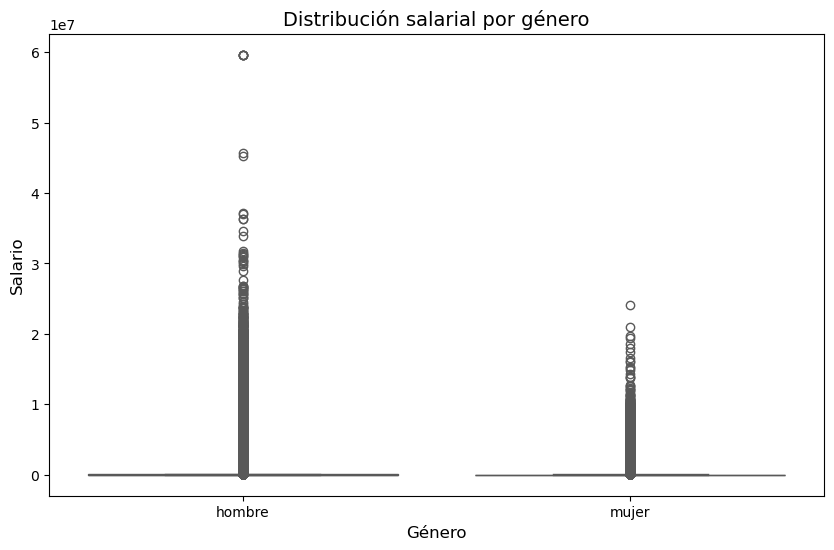

C:\Users\AFLONSO\AppData\Local\Temp\ipykernel_18388\433504542.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=encuestas_clean, x='TIPOJOR', y='SALBRUTO', palette="Set3")


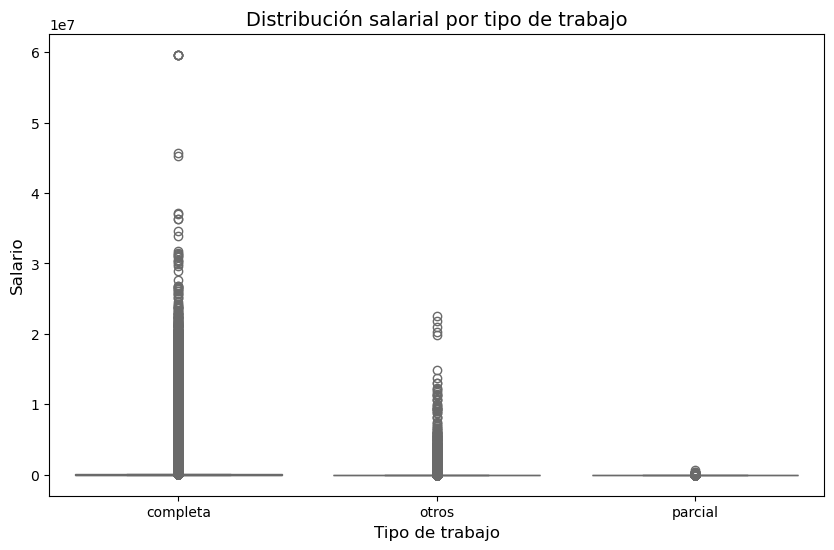

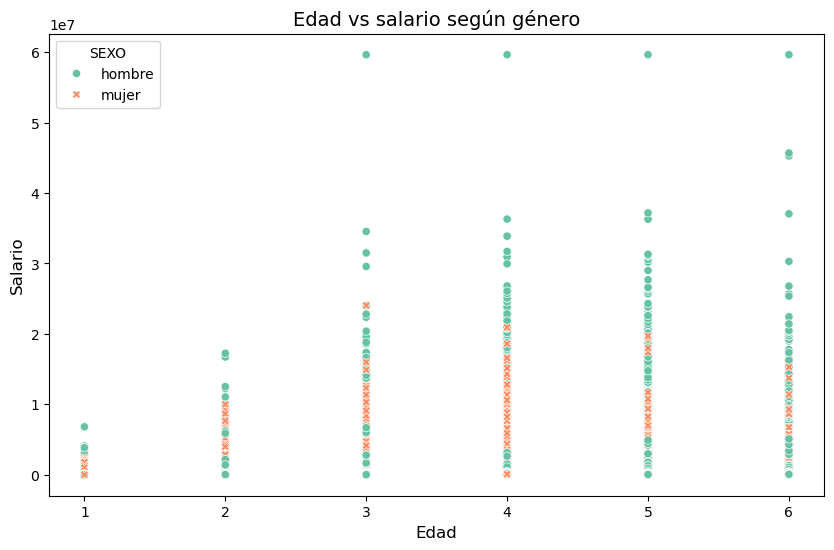

C:\Users\AFLONSO\AppData\Local\Temp\ipykernel_18388\433504542.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=encuestas_clean, x='ANOS2', y='SALBRUTO', hue='TIPOJOR', ci=None)


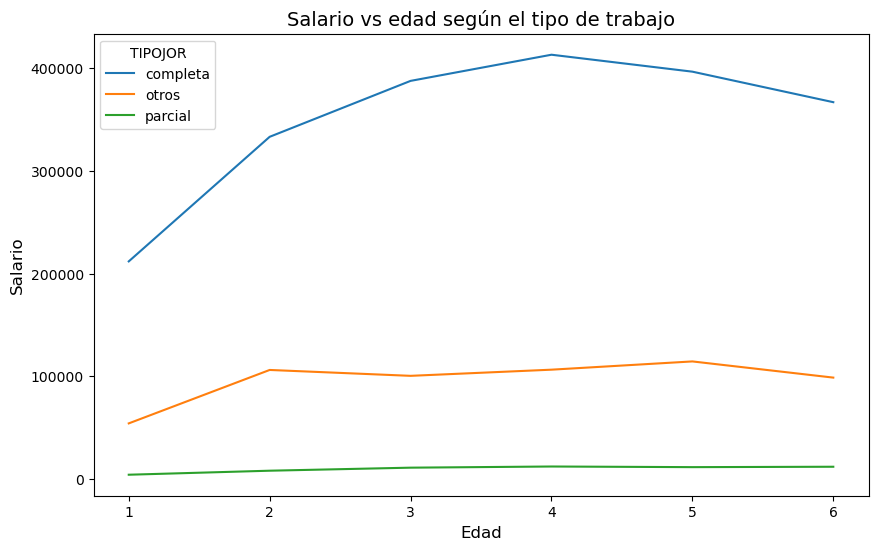

Correlación entre salario y edad:
             ANOS2  SALBRUTO
ANOS2     1.000000  0.013531
SALBRUTO  0.013531  1.000000


In [33]:
### BEGIN SOLUTION
import seaborn as sns

encuestas_clean = encuestas_timed.dropna(subset=['SALBRUTO', 'ANOS2'])              # Limpiamos y seleccionamos 

encuestas_clean['SEXO'] = encuestas_clean['SEXO'].astype('category')                
encuestas_clean['TIPOJOR'] = encuestas_clean['TIPOJOR'].astype('category')

plt.figure(figsize=(10, 6))                                                         # Pintamos
sns.boxplot(data=encuestas_clean, x='SEXO', y='SALBRUTO', palette="Set2")
plt.title('Distribución salarial por género', fontsize=14)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Salario', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=encuestas_clean, x='TIPOJOR', y='SALBRUTO', palette="Set3")
plt.title('Distribución salarial por tipo de trabajo', fontsize=14)
plt.xlabel('Tipo de trabajo', fontsize=12)
plt.ylabel('Salario', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=encuestas_clean, x='ANOS2', y='SALBRUTO', hue='SEXO', style='SEXO', palette="Set2")
plt.title('Edad vs salario según género', fontsize=14)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Salario', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=encuestas_clean, x='ANOS2', y='SALBRUTO', hue='TIPOJOR', ci=None)
plt.title('Salario vs edad según el tipo de trabajo', fontsize=14)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Salario', fontsize=12)
plt.show()

corr = encuestas_clean[['ANOS2', 'SALBRUTO']].corr()
print("Correlación entre salario y edad:")
print(corr)


### END SOLUTION


## Further analysis (40/100)


So far, we have covered just a fraction of the types of analysis and visualizations possible with this dataset.

In this last part, formulate your own questions, and to try to answer them.
You may re-use the data and results from the rest of the exercise, but you should process it futher and/or visualize it differently, in order to (hopefully) draw new conclusions.


Here are some examples of ways you can expand our analysis (although you are **highly encouraged to think of your own modifications**):

- Use other parts of the datasets.
    - Are there any differences between salary gaps between the public and private sectors?
    - Do all regions show the same trends, or are there regions with different patterns?
- Create new visualizations. For example:
    - Show the distribution of salary per type of job, or their distribution of ratios.
    - Show a heatmap of salary per region
    - Visualize the relationship between gender equality and region
    - Show means and variance for certain values (e.g., boxplots)
    - Use the regions to plot a map (advanced)
- Combine these datasets with others. For instance:
    - salarios.h5: contains aggregated data of salaries by age, region, and contract type
    - [GDP](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736167628&menu=enlaces&idp=1254735576581) and resources per region
    - [Number of universities](https://datos.gob.es/es/catalogo/e05073401-estructura-universitaria-resultados-nacionales-numero-de-centros-por-tipo-y-modalidad-de-la-universidad-y-tipo-y-naturaleza-del-centro)
    - [Enrolment in higher education](https://datos.gob.es/es/catalogo/e05073401-estructura-universitaria-resultados-nacionales-numero-de-centros-por-tipo-y-modalidad-de-la-universidad-y-tipo-y-naturaleza-del-centro)
    - [Success in undergraduate studies](https://datos.gob.es/es/catalogo/e05073401-indicadores-de-los-no-beneficiarios-de-becas-generales-de-la-age-y-pais-vasco-en-estudios-de-grado-resultados-por-universidad-tasas-de-abandono-del-estudio-cohortes-de-nuevo-ingreso-en-el-estudio-ambito-de-estudio-y-sexo)
    - [Statistics from other European countries](https://ec.europa.eu/eurostat/web/education-and-training/data/database)

## Show a heatmap of salary per region 

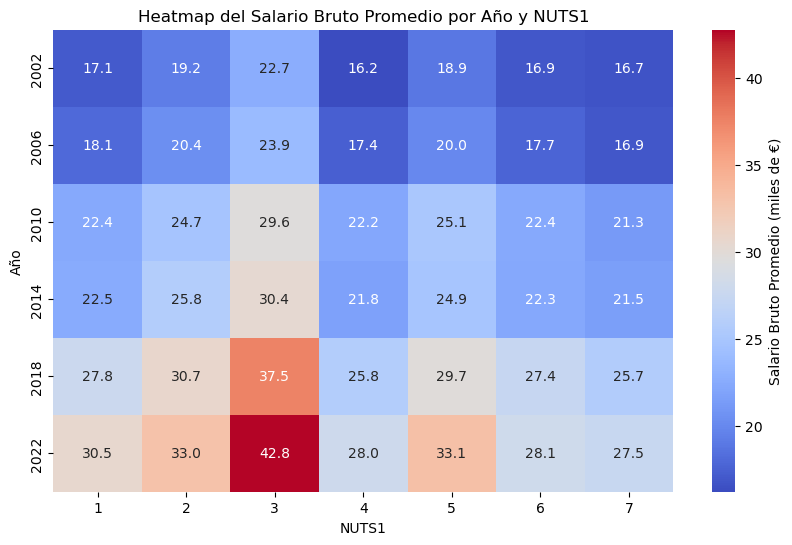

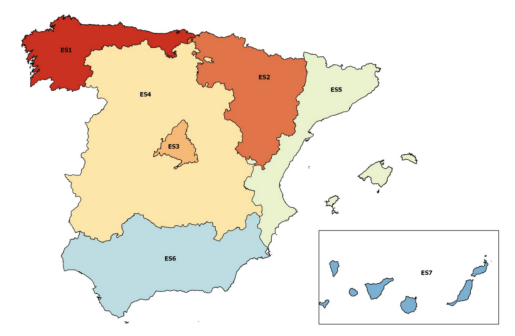

In [34]:
import matplotlib.image as mpimg

img = mpimg.imread('NUTS1/spainnuts1.png')
encuestas_heatmap = encuestas[['SALBRUTO', 'NUTS1']]
encuestas_heatmap
encuestas_heatmap_pivotado = encuestas_heatmap.pivot_table(index='NUTS1', columns='ANO', values='SALBRUTO', aggfunc='mean')
encuestas_heatmap_pivotado = encuestas_heatmap_pivotado.reset_index()
encuestas_heatmap_pivotado = encuestas_heatmap_pivotado.set_index('NUTS1')
encuestas_heatmap_pivotado = encuestas_heatmap_pivotado.T
encuestas_heatmap_pivotado_escalado = encuestas_heatmap_pivotado/1000
encuestas_heatmap_pivotado_escalado.index = pd.to_datetime(encuestas_heatmap_pivotado_escalado.index)
encuestas_heatmap_pivotado_escalado.index = encuestas_heatmap_pivotado_escalado.index.year
encuestas_heatmap_pivotado_escalado = encuestas_heatmap_pivotado_escalado.drop(1995, axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(
    encuestas_heatmap_pivotado_escalado, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".1f",  # Formato de 1 decimales
    cbar_kws={'label': 'Salario Bruto Promedio (miles de €)'}
)

plt.title('Heatmap del Salario Bruto Promedio por Año y NUTS1')
plt.xlabel('NUTS1')
plt.ylabel('Año')

# Mostrar el gráfico
plt.show()
plt.imshow(img)
plt.axis('off') 
plt.show()

## Visualize the relationship between gender equality and region

C:\Users\AFLONSO\AppData\Local\Temp\ipykernel_18388\1751264664.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_gender_region = encuestas_sector.groupby(['NUTS1', 'SEXO']).size().unstack(fill_value=0)


<Figure size 1000x600 with 0 Axes>

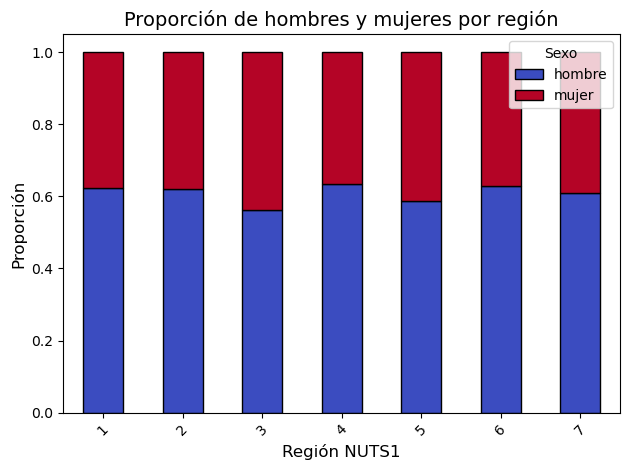

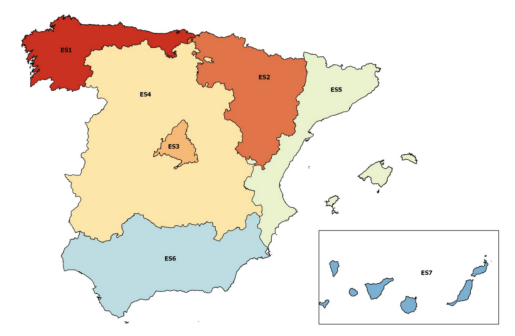

In [35]:
encuestas_sector = encuestas_timed.dropna(subset=['SALBRUTO', 'CNACE', 'NUTS1', 'TIPOJOR'])

encuestas_sector['CNACE'] = encuestas_sector['CNACE'].astype('category')
encuestas_sector['NUTS1'] = encuestas_sector['NUTS1'].astype('category')
encuestas_sector['TIPOJOR'] = encuestas_sector['TIPOJOR'].astype('category')

grouped_gender_region = encuestas_sector.groupby(['NUTS1', 'SEXO']).size().unstack(fill_value=0)
prop_gender_region = grouped_gender_region.div(grouped_gender_region.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
prop_gender_region.plot(kind='bar', stacked=True, colormap='coolwarm', edgecolor='black')
plt.title('Proporción de hombres y mujeres por región', fontsize=14)
plt.xlabel('Región NUTS1', fontsize=12)
plt.ylabel('Proporción', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sexo', loc='upper right')
plt.tight_layout()
plt.show()

plt.imshow(img)
plt.axis('off') 
plt.show()

##  Display of population growth rate by region

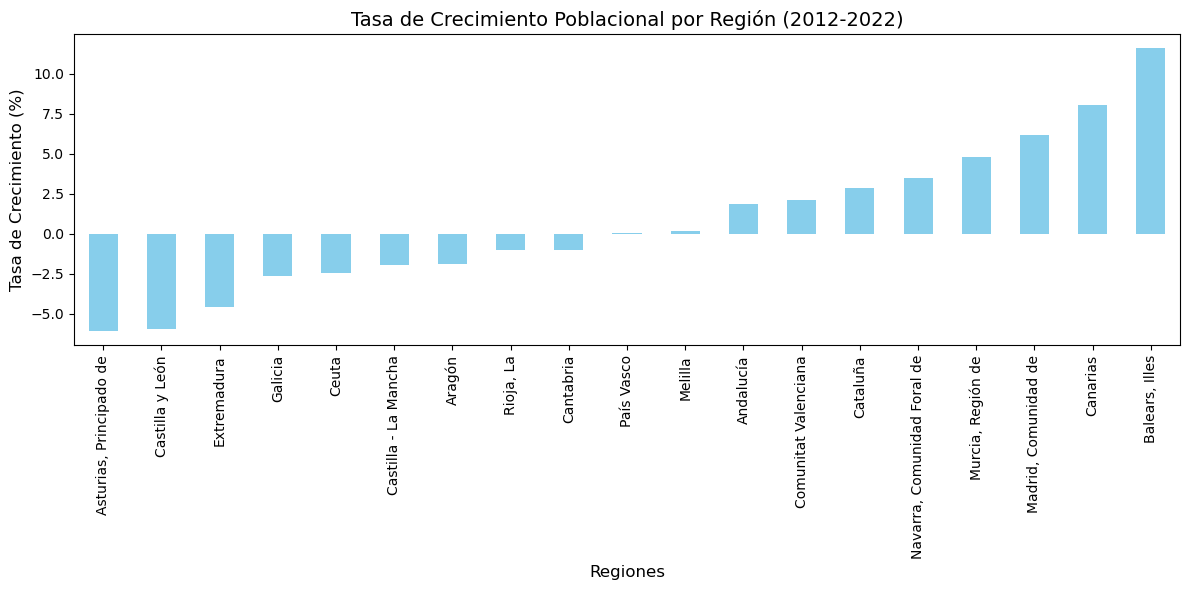

In [36]:
crecimiento_poblacional = ((censo_regiones.loc["2022-07-01"] - censo_regiones.loc["2012-07-01"]) / censo_regiones.loc["2012-07-01"]) * 100          # Calculamos la tasa de crecimiento porcentual de la población por región

plt.figure(figsize=(12, 6))                                                                                                                         # Graficamos las tasas de crecimiento
crecimiento_poblacional.sort_values().plot(kind='bar', color='skyblue')
plt.title('Tasa de Crecimiento Poblacional por Región (2012-2022)', fontsize=14)
plt.xlabel('Regiones', fontsize=12)
plt.ylabel('Tasa de Crecimiento (%)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


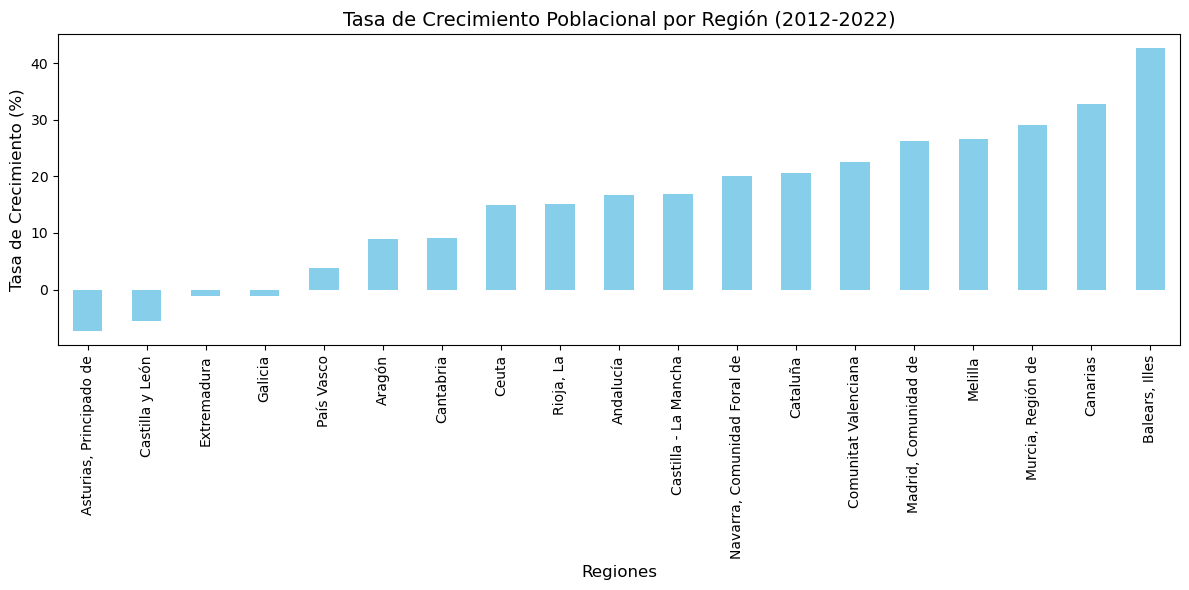

In [37]:
crecimiento_poblacional = ((censo_regiones.loc["2022-07-01"] - censo_regiones.loc["1995-07-01"]) / censo_regiones.loc["2012-07-01"]) * 100          # Calculamos la tasa de crecimiento porcentual de la población por región

plt.figure(figsize=(12, 6))                                                                                                                         # Graficamos las tasas de crecimiento
crecimiento_poblacional.sort_values().plot(kind='bar', color='skyblue')
plt.title('Tasa de Crecimiento Poblacional por Región (2012-2022)', fontsize=14)
plt.xlabel('Regiones', fontsize=12)
plt.ylabel('Tasa de Crecimiento (%)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Wage gap analysis

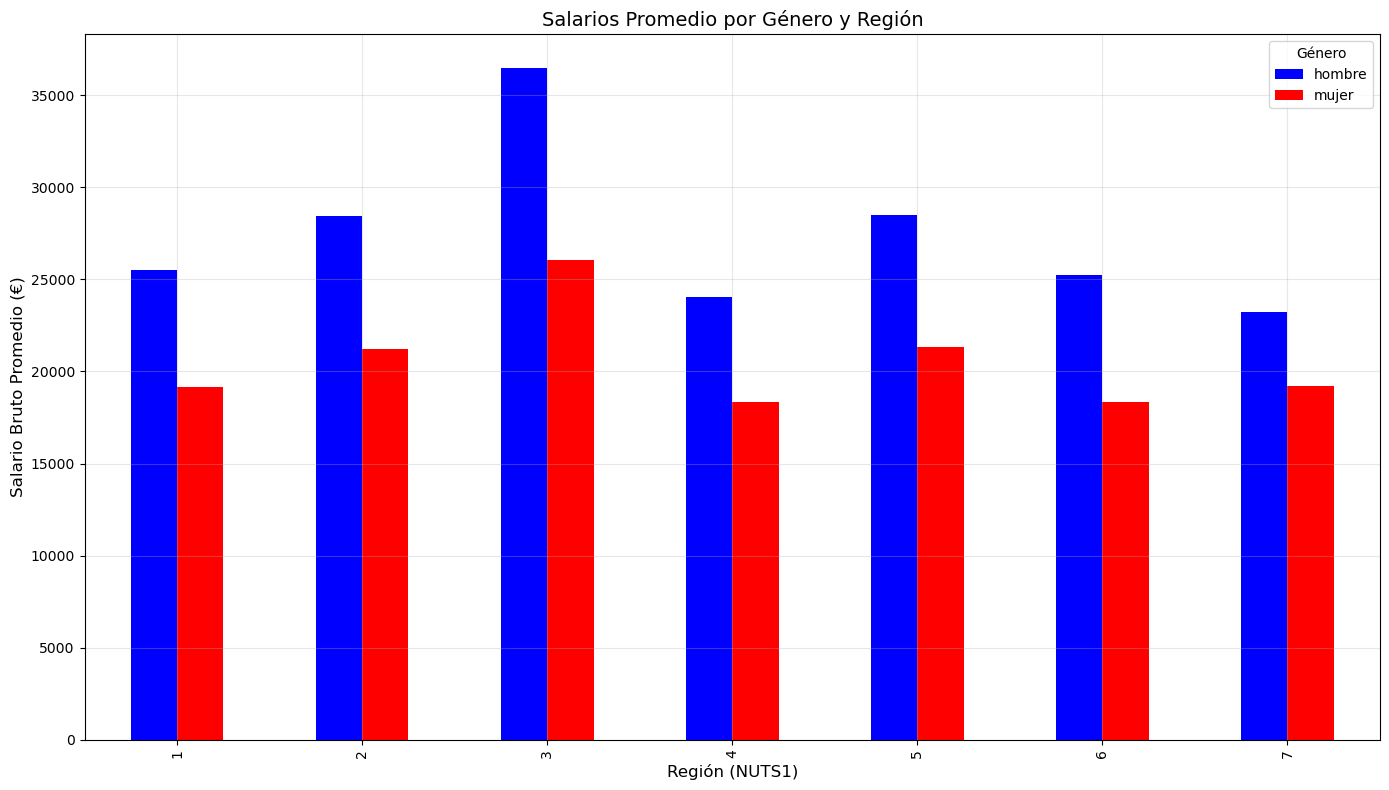

In [38]:
encuestas_timed2 = pd.concat([df_Datos_INE_2002, df_Datos_INE_2006, df_Datos_INE_2010, df_Datos_INE_2014, df_Datos_INE_2018, df_Datos_INE_2022], ignore_index=True)
encuestas_timed2['ANO'] = pd.to_datetime(encuestas_timed2['ANO'], format='%Y')
encuestas_timed2 = encuestas_timed2.set_index('ANO')  
mapa_genero = {
    1:'hombre',
    6:'mujer'
}
encuestas_timed2['SEXO'] = encuestas_timed2['SEXO'].map(mapa_genero)
salario_por_genero_region = encuestas_timed2.groupby(['NUTS1', 'SEXO'])['SALBRUTO'].mean().unstack()
salario_por_genero_region.plot(kind='bar', figsize=(14, 8), color=['blue', 'red'])
plt.title('Salarios Promedio por Género y Región', fontsize=14)
plt.xlabel('Región (NUTS1)', fontsize=12)
plt.ylabel('Salario Bruto Promedio (€)', fontsize=12)
plt.legend(title='Género')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

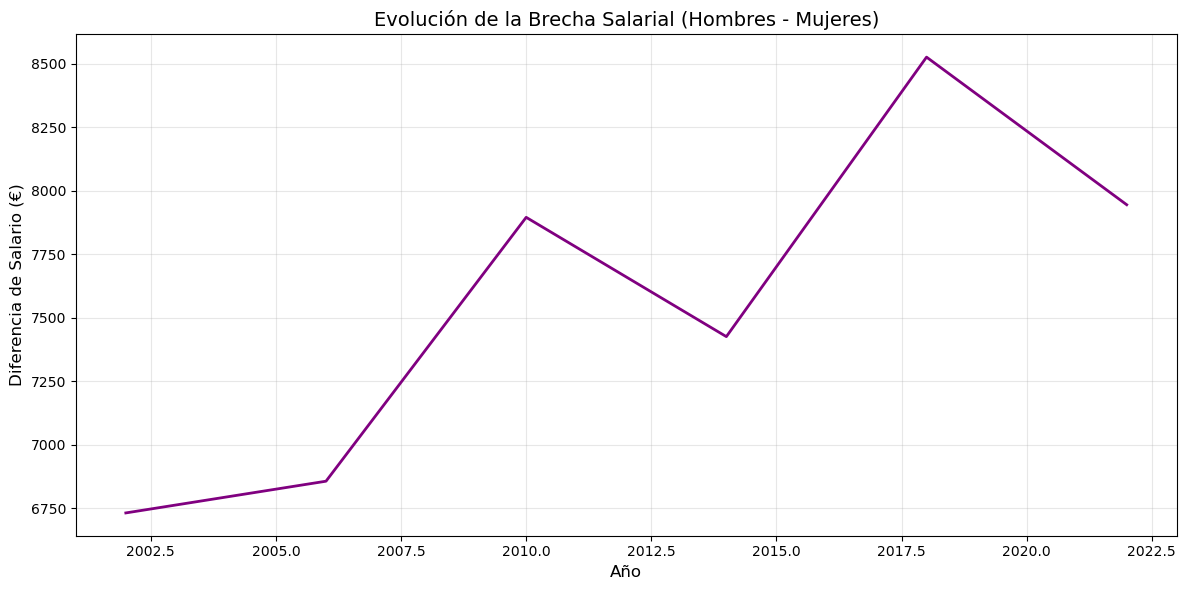

In [39]:
salario_por_ano_genero = encuestas_timed2.groupby([encuestas_timed2.index.year, 'SEXO'])['SALBRUTO'].mean().unstack()
brecha_salarial = salario_por_ano_genero['hombre'] - salario_por_ano_genero['mujer']
brecha_salarial.plot(kind='line', figsize=(12, 6), color='purple', linewidth=2)
plt.title('Evolución de la Brecha Salarial (Hombres - Mujeres)', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Diferencia de Salario (€)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Analysis of salary differences between men and women by type of work

Text(0.5, 0, 'Tipo de jornada')

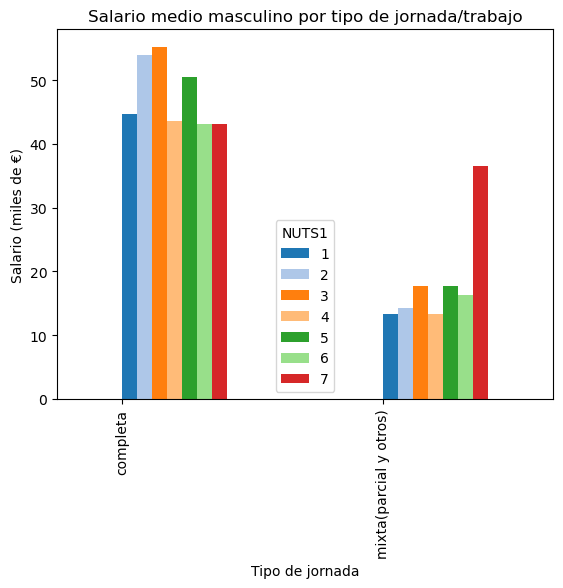

In [ ]:

hombres = encuestas[encuestas['SEXO'] == 'hombre']                                                                      # Filtramos por género
mujeres = encuestas[encuestas['SEXO'] == 'mujer']

salario_hombres = hombres.groupby(['TIPOJOR', 'NUTS1'])['SALBRUTO'].mean().unstack()                                    # Promedio de salario por tipo de trabajo y género
salario_mujeres = mujeres.groupby(['TIPOJOR', 'NUTS1'])['SALBRUTO'].mean().unstack()
                                                                                                            
salario_hombres = salario_hombres/10000                                                                                 # Graficamos a los hombres
salario_hombres.loc['mixta(parcial y otros)'] = salario_hombres.loc['otros'] + salario_hombres.loc['parcial']
salario_hombres.drop(['otros', 'parcial'], inplace=True)
colores = sns.color_palette("tab20")
salario_hombres.plot(kind='bar', stacked=False, position=0, width=0.4, color=colores, label='Hombres')
plt.title('Salario medio masculino por tipo de jornada/trabajo')
plt.ylabel('Salario (miles de €)')
plt.xlabel('Tipo de jornada')



Text(0.5, 0, 'Tipo de jornada')

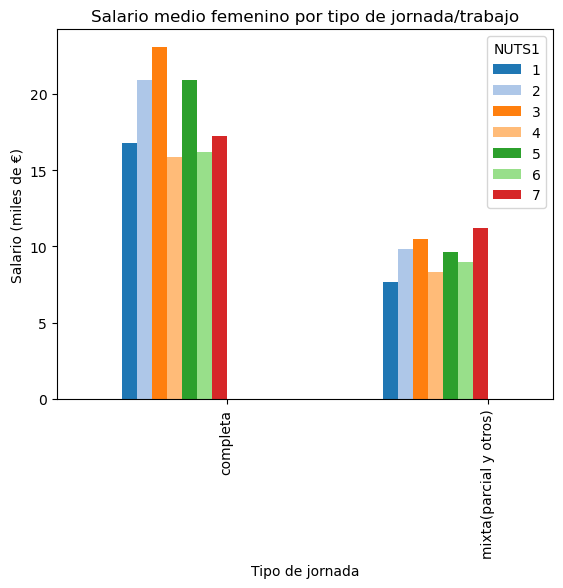

In [163]:

hombres = encuestas[encuestas['SEXO'] == 'hombre']                                                                  # Filtramos por género
mujeres = encuestas[encuestas['SEXO'] == 'mujer']

salario_hombres = hombres.groupby(['TIPOJOR', 'NUTS1'])['SALBRUTO'].mean().unstack()                                # Promedio de salario por tipo de trabajo y género
salario_mujeres = mujeres.groupby(['TIPOJOR', 'NUTS1'])['SALBRUTO'].mean().unstack()


salario_mujeres = salario_mujeres/10000
salario_mujeres.loc['mixta(parcial y otros)'] = salario_mujeres.loc['otros'] + salario_mujeres.loc['parcial']
salario_mujeres.drop(['otros', 'parcial'], inplace=True)
colores = sns.color_palette("tab20")
salario_mujeres.plot(kind='bar', stacked=False, position=1, width=0.4, color=colores, label='Mujeres')
plt.title('Salario medio femenino por tipo de jornada/trabajo')
plt.ylabel('Salario (miles de €)')
plt.xlabel('Tipo de jornada')

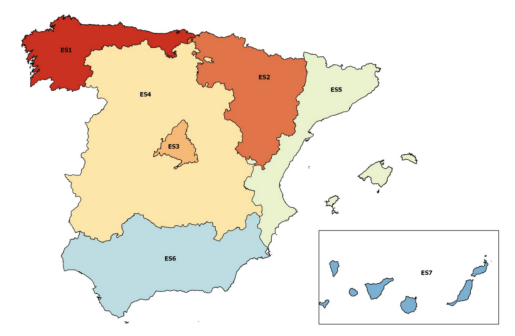

In [164]:
plt.imshow(img)
plt.axis('off') 
plt.show()

## Average base salary by education level and by region.

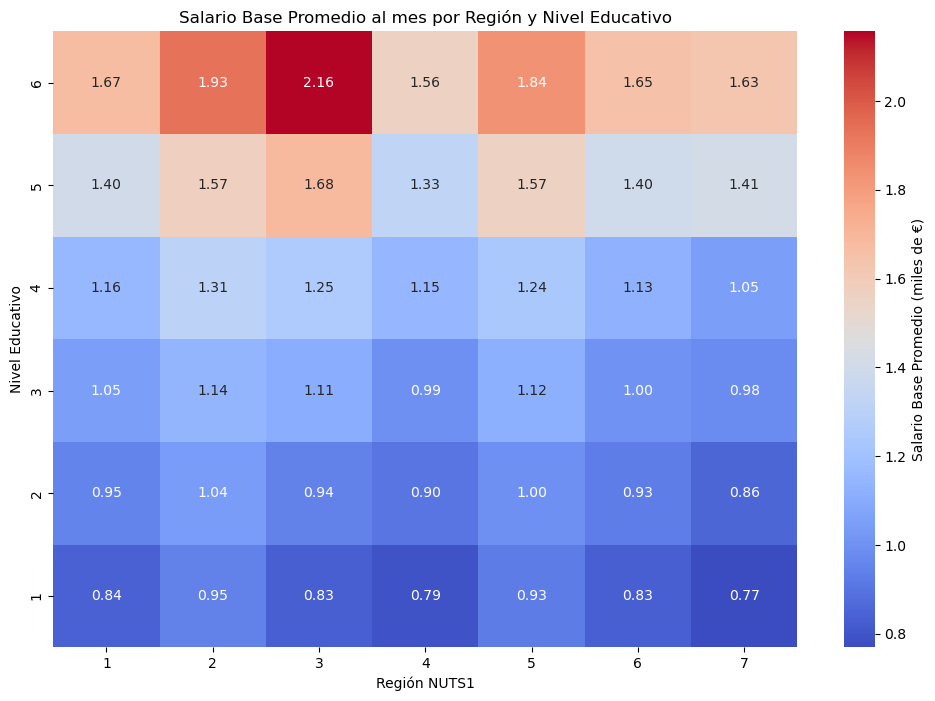

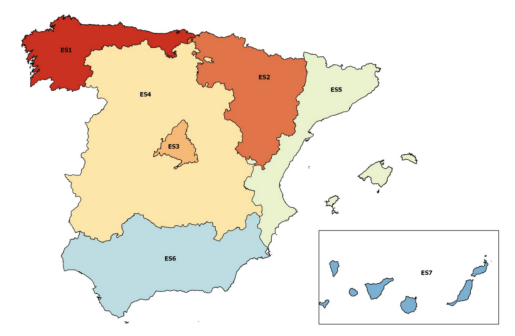

In [42]:
# datos_INE_1995 tiene 8 valores para ESTUDIOS
# datos_INE_2002 tiene 8 valores para ESTUDIOS
# datos_INE_2006 tiene 8 valores para ESTUDIOS
# datos_INE_2010 tiene 8 valores para ESTUDIOS
# datos_INE_2014 tiene 7 valores para ESTUDIOS
# datos_INE_2018 tiene 7 valores para ESTUDIOS
# datos_INE_2022 tiene 7 valores para ESTUDIOS

encuestas_2002_2010 = pd.concat([df_Datos_INE_2002, df_Datos_INE_2006, df_Datos_INE_2010], ignore_index=True)                       # No cogemos los datos de 1995 ya que están en pesetas
encuestas_2014_2022 = pd.concat([df_Datos_INE_2014, df_Datos_INE_2018, df_Datos_INE_2022], ignore_index=True)

encuestas_2002_2010['ESTU']
encuestas_2002_2010 = encuestas_2002_2010[['ESTU', 'SALBASE', 'NUTS1']]                                                             # Esogemos las columnas indispensables                
encuestas_2014_2022 = encuestas_2014_2022[['ESTU', 'SALBASE', 'NUTS1']]

encuestas_2002_2010 = encuestas_2002_2010.dropna(subset=['ESTU', 'SALBASE', 'NUTS1'])                                               # Eliminamos valores nulos
encuestas_2014_2022 = encuestas_2014_2022.dropna(subset=['ESTU', 'SALBASE', 'NUTS1'])  
                                                                      
'''
Info datos 1995-2010:                                                                                                               # Generamos nuevo criterio para ESTU
Código	Descripción	
1	Sin estudios.	
2	Educación primaria.	
3	Educación secundaria I.	
4	Educación secundaria II.	
5	Formación profesional de grado medio.	
6	Formación profesional de grado superior.	
7	Diplomados universitarios o equivalente.	
8	Licenciados, ingenieros superiores y doctores. 	
'''
'''
Info datos 2010-2022:
Código	Descripción	
1	 Menos que primaria	
2	 Educación primaria	
3	 Primera etapa de educación secundaria	
4	 Segunda etapa de eduación secundaria	
5	 Enseñanzas de formación profesional de grado superior y similares	
6	 Diplomados universitarios y similares	
7	 Licenciados y similares, y doctores universitarios	
'''
'''
Nueva gerarquía para el análisis:
Códgo   Descripción
1   Sin estudios
2   Educación primaria
3   Educación Secundaria Obligatoria
4   Formación Profesional
5   Diplomados Universitarios
6   Licenciados, ingenieros y doctores                                                                                              
'''
mapeo_bien_rechulo_2002_2010 = {                                                                                                    # Creamos el mapa
    1: 1,
    2: 2,
    3: 3,
    4: 3,  # Los valores 3 y 4 del sistema viejo se agrupan como 3 en el nuevo.
    5: 4,
    6: 4,  # Los valores 5 y 6 del sistema viejo se agrupan como 4 en el nuevo.
    7: 5,
    8: 6
}

mapeo_bien_rechulo_2014_2022 = {
    1: 1,
    2: 2,
    3: 3,
    4: 3,  # Agrupación de los códigos 3 y 4 como 3
    5: 4,
    6: 5,
    7: 6
}

encuestas_2002_2010['ESTU'] = encuestas_2002_2010['ESTU'].map(mapeo_bien_rechulo_2002_2010)                                         # Mapeamos los datos
encuestas_2014_2022['ESTU'] = encuestas_2014_2022['ESTU'].map(mapeo_bien_rechulo_2014_2022)
encuestas_heatmap2 = pd.concat([encuestas_2002_2010,encuestas_2014_2022], ignore_index=True)                                        # Concatenamos los dos dataframes, uno debajo del otro
salary_by_education = encuestas_heatmap2.groupby('ESTU')['SALBASE'].describe()                                                      # Agrupar por nivel educativo y calcular estadísticas descriptivas del salario

heatmap_data = encuestas_heatmap2.pivot_table(values='SALBASE', index='ESTU', columns='NUTS1', aggfunc='mean')                      # Agrupar por nivel educativo y región (NUTS1) y calcular la media del salario

heatmap_data = heatmap_data/1000

plt.figure(figsize=(12, 8))                                                                                                         # Crear un heatmap
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Salario Base Promedio (miles de €)'})
plt.gca().invert_yaxis()
plt.title('Salario Base Promedio al mes por Región y Nivel Educativo')
plt.xlabel('Región NUTS1')
plt.ylabel('Nivel Educativo')
plt.show()

plt.imshow(img)                                                                                                                     # Mostramos el mapa de España
plt.axis('off') 
plt.show()

# Realizado por Alfonso Jimena Ruiz


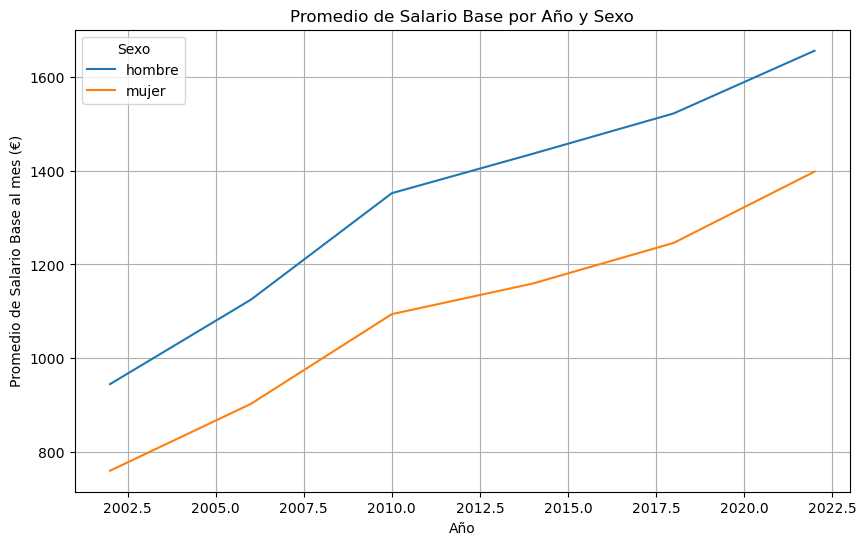

In [43]:

data_proportion = pd.concat([df_Datos_INE_2002, df_Datos_INE_2006, df_Datos_INE_2010, df_Datos_INE_2014, df_Datos_INE_2018, df_Datos_INE_2022], ignore_index=True)     # Concatenamos los DataFrames

sexo_map = {1: 'hombre', 6: 'mujer'}                                                                                                                                   # Crear mapa
data_proportion['SEXO'] = data_proportion['SEXO'].map(sexo_map)                                                                                                                    # Mapear

avg_salary = data_proportion.groupby(['ANO', 'SEXO'])['SALBASE'].mean().reset_index()                                                                                  # Agrupar por Año y Sexo y calcular el promedio del Salario Base

plt.figure(figsize=(10, 6))                                                                                                                                            # Crear el gráfico
for sexo in avg_salary['SEXO'].unique():
    subset = avg_salary[avg_salary['SEXO'] == sexo]
    plt.plot(subset['ANO'], subset['SALBASE'], label=f'{sexo}')

plt.xlabel('Año')
plt.ylabel('Promedio de Salario Base al mes (€)')
plt.title('Promedio de Salario Base por Año y Sexo')
plt.legend(title='Sexo')
plt.grid(True)
plt.show()